In [1]:
import sys
if "pyodide" in sys.modules:
    import micropip
    await micropip.install('stdpopsim')
    await micropip.install('demesdraw')
    await micropip.install('jupyterquiz')
    await micropip.install('tskit_arg_visualizer')
else:
    !pip install -q stdpopsim
    !pip install -q msprime
    !pip install -q demesdraw
    !pip install -q jupyterquiz
    !pip install -q "tskit_arg_visualizer>=0.1.0"

In [2]:
## NB this cell is here simply to create example_ARG.trees: normally this file
# will be loaded from a stored version, so this call can be deleted from the main workbook

from itertools import pairwise
import string
import warnings

import msprime
import numpy as np
import stdpopsim
import tskit
import tskit_arg_visualizer as argviz

species = stdpopsim.get_species("HomSap")
model = species.get_demographic_model("OutOfAfrica_2T12")
contig = species.get_contig("chr1", mutation_rate=0, left=0, right=1e3)
samples = {"AFR": 3, "EUR": 2}
engine = stdpopsim.get_engine("msprime")

extra_nodes = msprime.NodeType.COMMON_ANCESTOR | msprime.NodeType.RECOMBINANT

# 844 a good example
for random_seed in range(844, 10000):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ts = engine.simulate(model, contig, samples, additional_nodes=extra_nodes,
                coalescing_segments_only=False, random_seed=random_seed,
        )
    ts = ts.trim()
    re_pairs = np.where(ts.nodes_flags & msprime.NODE_IS_RE_EVENT)[0].reshape((-1,2))
    diamonds, nondiamonds = [], set()
    for u1, u2 in re_pairs:
        if np.all(ts.edges_parent[ts.edges_child == u1] == ts.edges_parent[ts.edges_child == u2]):
            diamonds.append((u1, u2))
        else:
            nondiamonds.update({u1, u2})
    
    immediate = [
        nd_pair for nd_pair in re_pairs
        if len(set(ts.edges_parent[np.isin(ts.edges_child, nd_pair)]) & nondiamonds) > 0
    ]
    
    # require a diamond, a RE node pair that is an immediate descendant of another, and a
    # non-topology-changing (height only) recombination
    
    if len(diamonds) and len(immediate) and len(diamonds) < np.sum(ts.nodes_flags == msprime.NODE_IS_CA_EVENT):
        print("Temporarily simulated the ARG to use, and saved it.")
        print("Diamond", diamonds, ts.edges_parent[diamonds[0][0]], ts.edges_parent[diamonds[0][1]])
        print("RE-to-RE descent", immediate, ts.edges_parent[immediate[0][0]])
        tables = ts.dump_tables()
        nodes_time = tables.nodes.time
        nodes_time[26] *= 0.97  # Adjust the time, to place this <30_000 gens
        nodes_time[[24, 25]] *= 0.9  # Adjust the time, so that labels don't overlap
        nodes_time[23] *= 1.2  # Adjust the time, so that labels don't overlap
        nodes_time[18] *= 0.9  # Adjust the time, so that labels don't overlap
        tables.nodes.time = nodes_time
        tables.simplify([2, 4, 9, 8, 5, 6, 1, 3, 7, 0], keep_unary=True)
        tables.nodes.metadata_schema = tskit.MetadataSchema.permissive_json()
        for i in np.where(tables.nodes.flags & tskit.NODE_IS_SAMPLE)[0]:
            tables.nodes[i] = tables.nodes[i].replace(metadata={'label': string.ascii_uppercase[i]})
        tables.individuals.metadata_schema = tskit.MetadataSchema.permissive_json()
        names = ['Bob', 'Eve' , 'Sam', 'Lucy', 'Joe',]
        for i in range(tables.individuals.num_rows):
            tables.individuals[i] = tables.individuals[i].replace(metadata={'name': names[i]})
        ts = tables.tree_sequence()
        mutation_rate = 1e-7
        rseed = 255  # Pick a seed that gives 2 mutations at one of the sites
        ts = msprime.sim_mutations(ts, rate=mutation_rate, random_seed=255)  # Add mutations to the existing ARG
        if (ts.num_mutations != 13):
            raise RuntimeError("Didn't get expected results: you could be running on a non-tested OS")
        print("Using msprime simulation with random seed", random_seed, "and mutation seed", rseed)
        break

ts.dump("example_ARG.trees")

"""
d3arg = argviz.D3ARG.from_ts(ts)
# Set some styles
colours = ['green', 'blue', 'cyan']
d3arg.set_node_styles({u: {"fill": colours[status]} for u, status in enumerate(node_unary_status(ts))})
d3arg.set_node_styles({u: {"fill": "red"} for u in np.where(ts.nodes_flags & msprime.NODE_IS_RE_EVENT)[0]})
d3arg.set_node_styles({u: {"fill": "grey", "symbol": "d3.symbolSquare"} for u in ts.samples()})
d3arg.draw(edge_type="line")
"""

### Hack below - can be removed when questions are saved to JSON files named Q1.json, Q2.json etc
# This allows answers to be hidden from the casual viewer. Then we can simply set the url to a string instead of a class
class FakeURL(dict):
    def __add__(self, prefix):
        return self[prefix]
WB1_base = FakeURL()
true, false= True, False  # just to allow easy conversion to JSON format
### hack ends

WB1_base["Q1.json"] = [{
    "question": "What genomic span is passed on to sample node 6 through the route via node 15? The span is the total length of the genome region passed on (i.e. the right minus the left position)",
    "type": "numeric",
    "answers": [
        {"type": "value", "value": 930, "correct": true, "feedback": "Yes, it covers positions 0 to 930."},
        {"type": "default", "feedback": "Try hovering over the edges below node 15."}
    ]
}]
WB1_base["Q2.json"] = [{
    "question": "What does SPR stand for?",
    "type": "many_choice",
    "answers": [
        {"answer": "Subtree Prune and Regraft", "correct": true},
        {"answer": "Strand Pairing Resolution", "correct": false},
        {"answer": "Single-Point Reversion", "correct": false},
        {"answer": "Slippery Puzzle Reorganization", "correct": false, "feedback": "???."}
    ]}, {
    "question": "What is the TMRCA, or time to the most recent common ancestor (in generations) between nodes 0 and 9 at the left hand end of this ARG?",
    "type": "numeric",
    "answers": [
        {"type": "value", "value": 38472, "correct": true},
        {"type": "value", "value": 31, "correct": false, "feedback": "That's the node ID. What time is associated with that node."},
        {"type": "default", "feedback": "Try hovering over the last part of the genome, and looking at the axis labels."}
    ]},{
    "question": "What is the name of the structure in which two lineages split but immediately re-join, as seen just below node 26",
    "type": "many_choice",
    "answers": [
        {"answer": "Diamond", "correct": true},
        {"answer": "Loop", "correct": false},
        {"answer": "Bubble", "correct": false, "feedback": "This term is sometimes used, but is not standard"},
        {"answer": "Cycle", "correct": false}
    ]
}]

WB1_base["Q3.json"] = [{
    "question": "(Hard!) Only one recombination event results in a tree that shows a new topological relationship between the samples. By looking at the graph and the local trees, can you identify which one it is? Enter its breakpoint position below:",
    "type": "numeric",
    "answers": [
        {"type": "value", "value": 930, "correct": true, "feedback": "Yes (coincidentally this is the last breakpoint)"},
        {"type": "default", "feedback": "Hint: look at the breakpoints on the X axis of the tree-by-tree plot: which marks the transition between two differently shaped trees?"}
    ]
}]

WB1_base["Q4.json"] = [{
    "question": "The first two breakpoints along the genome happen to correspond to recombination at the top of the ARG. How many different root heights does this cause?",
    "type": "numeric",
    "answers": [
        {"type": "value", "value": 3, "correct": true},
        {"type": "default", "feedback": "Hint: look at the local trees"}
    ]
}]

WB1_base["Q5.json"] = [{
    "question": "How would you classify the recombination node(s) 20/21",
    "type": "many_choice",
    "answers": [
        {"answer": "Non-coalescent / always unary", "correct": true, "feedback": "By construction, in a full ARG recombination nodes are never coalescent"},
        {"answer": "Partially-coalescent / locally unary", "correct": false},
        {"answer": "All-coalescent / never unary", "correct": false}
    ]},{
    "question": "How would you classify node 17",
    "type": "many_choice",
    "answers": [
        {"answer": "Non-coalescent / always unary", "correct": false},
        {"answer": "Part-coalescent / locally unary", "correct": false},
        {"answer": "All-coalescent / never unary", "correct": true}
    ]},{
    "question": "How would you classify node 26",
    "type": "many_choice",
    "answers": [
        {"answer": "Non-coalescent / always unary", "correct": true, "feedback": "Some 'common ancestor' nodes with 2 children in the full ARG never represent local coalescence"},
        {"answer": "Part-coalescent / locally unary", "correct": false},
        {"answer": "All-coalescent / never unary", "correct": false}
    ]},{
    "question": "How would you classify node 15",
    "type": "many_choice",
    "answers": [
        {"answer": "Non-coalescent / always unary", "correct": false},
        {"answer": "Part-coalescent / locally unary", "correct": true, "feedback": "It is only coalescent on the left side of the genome: it is unary to the right of position 930"},
        {"answer": "All-coalescent / never unary", "correct": false}
    ]
}]


WB1_base["Q6.json"] = [{
    "question": "In the population-coloured ARG plot, what colour do you think represents nodes from the African population",
    "type": "many_choice",
    "answers": [
        {"answer": "green", "correct": true, "feedback": "Yes, the deepest divergences are African: in fact, even between the European genomes, some coalescences trace back into Africa"},
        {"answer": "blue", "correct": false},
    ]
}]

WB1_base["Q7.json"] = [{
    "question": "One of the sites has two mutations. Can you identify the position of that site by looking at both the tree-by-tree and the interactive ARG plot?",
    "type": "numeric",
    "answers": [
        {"type": "value", "value": 5, "correct": true, "feedback": "Yes (coincidentally this is the first position)"},
        {"type": "default", "feedback": "Hint: duplicate mutations will simultaneously be highlighted when hovering over them in the visualizer"}
    ]
}]

WB1_base["Q8.json"] = [{
    "question": "What is the allelic state of the sample with node ID 2 at position 5?",
    "type": "many_choice",
    "answers": [
        {"answer": "A", "correct": false},
        {"answer": "C", "correct": false},
        {"answer": "G", "correct": false},
        {"answer": "T", "correct": true}
    ]}, {
    "question": "What is the ancestral state at position 5?",
    "type": "many_choice",
    "answers": [
        {"answer": "A", "correct": true},
        {"answer": "C", "correct": false},
        {"answer": "G", "correct": false},
        {"answer": "T", "correct": false}
    ]}, {
    "question": "By looking at the ARG or tree visualizations, the mutation responsible for this state in sample 2 is above which node?",
    "type": "many_choice",
    "answers": [
        {"answer": "12", "correct": false},
        {"answer": "13", "correct": true},
        {"answer": "31", "correct": false},
        {"answer": "This allelic state is the ancestral state, so does not correspond to a mutation in the ARG ", "correct": false,
        "feedback": "It is true that ancestral states are not represented by a mutation in the ARG, but the state C here is a derived state, so it *is* associated with a mutation"}
    ]
}]

WB1_base["Q9.json"] = [{
    "question": "In the ARG above, what mutation groups together samples 7, 8, and 9?",
    "type": "many_choice",
    "answers": [
        {"answer": "C mutates to T at position 215", "correct": true},
        {"answer": "T mutates to C at position 215", "correct": false, "feedback": "You have the position right, but the derived state is T."},
        {"answer": "G mutates to T at position 92", "correct": false},
        {"answer": "C mutates to G at position 560", "correct": false}
    ]}, {
    "question": "What ARG node does that mutation allow us to infer?",
    "type": "numeric",
    "answers": [
        {"type": "value", "value": 16, "correct": true, "feedback": "Yes, it's the node below the mutation."},
        {"type": "value", "value": 19, "correct": false, "feedback": "No, that node groups together more than 7, 8, and 9."}
    ]},{
    "question": "Do any mutations allow us to resolve the relationship between samples 4, 5, and 6?",
    "type": "many_choice",
    "answers": [
        {"answer": "No", "correct": true, "feedback": "In fact, we can't even resolve the relative closeness of 4 versus 5 versus 6 to the (7,8,9) group"},
        {"answer": "Yes", "correct": false}
    ]}, {
    "question": "How many mutations are uninformative about the structure (topology) of the ARG?",
    "type": "numeric",
    "answers": [
        {"type": "value", "value": 2, "correct": true, "feedback": "Yes, the two so-called singletons, immediately above node 3 and node 4."},
        {"type": "default", "feedback": "Incorrect (hint: mutations above a single node do not group samples together)."}
    ]
}]

WB1_base["Q10.json"] = [{
    "question": "What is the interpretation of the genetic diversity, π in terms of branch lengths?",
    "type": "many_choice",
    "answers": [
        {"answer": "The average time of all internal nodes", "correct": false},
        {"answer": "Twice the average TMRCA between all pairs of samples", "correct": true},
        {"answer": "The average branch lengths between all pairs of samples", "correct": true},
        {"answer": "The span-weighted average branch length of the local trees", "correct": false,
        "feedback": "This is the equivalent of the number of segregating sites (under the infinite-sites model)"}
    ]
}]



Temporarily simulated the ARG to use, and saved it.
Diamond [(np.int64(24), np.int64(25))] 24 25
RE-to-RE descent [array([27, 28])] 26
Using msprime simulation with random seed 845 and mutation seed 255


In [3]:
# This could be put into a module so it can be loaded in one line
import sys
import numpy as np
from IPython.display import HTML
class Workbook:
    @staticmethod
    def setup():
        display(HTML(
            "<style type='text/css'>" +
            ".exercise {background-color: yellow; color: black; font-family: 'serif'; font-size: 1.2em}" +
            ".exercise code {font-size: 0.7em}" +
            "</style>" + 
            "<h4>✅ Your notebook is ready to go!</h4>" +
            ("" if "pyodide" not in sys.modules else '''
(to reset, click the following button and reload&rarr;<button type="button" id="button_for_indexeddb">Clear JupyterLite local storage</button>)
<script>
window.button_for_indexeddb.onclick = function(e) {
    window.indexedDB.open('JupyterLite Storage').onsuccess = function(e) {
        // There are also other tables that we're not clearing:
        // "counters", "settings", "local-storage-detect-blob-support"
        let tables = ["checkpoints", "files"];

        let db = e.target.result;
        let t = db.transaction(tables, "readwrite");

        function clearTable(tablename) {
            let st = t.objectStore(tablename);
            st.count().onsuccess = function(e) {
                console.log("Deleting " + e.target.result +
                " entries from " + tablename + "...");
                st.clear().onsuccess = function(e) {
                    console.log(tablename + " is cleared!");
                }
            }
        }

        for (let tablename of tables) {
            clearTable(tablename);
        }
        alert("Local changes reverted. Now reload the page.")
    }
};
</script>''')
    ))

    def node_coalescence_status(arg):
        """
        Uses the num_children_array attribute to find nodes that represent local coalescence.
        See https://tskit.dev/tskit/docs/latest/python-api.html#tskit.Tree.num_children_array
        Returns an array of length num_nodes containing 0 if a node never has any coalescent
        segments, 1 if some segments of the node are coalescent and some unary, and 2 if
        all node segments represent a local coalescence point.
        """
        has_unary = np.zeros(arg.num_nodes + 1, dtype=int)
        has_coal = np.zeros(arg.num_nodes + 1, dtype=int)
        for tree in arg.trees():
            has_unary[tree.num_children_array == 1] = 1
            has_coal[tree.num_children_array > 1] = 1
        status = np.where(has_coal, np.where(has_unary, 1, 2), 0)
        return status[:-1] # remove the last array value, which is the "virtual root": see docs


class Workbook1(Workbook):
    url = WB1_base  # Put the real URL base string (ending in "/") here, once JSON question files have been made available at that URL


# Introduction

### Background reading and skills required

ARGs provide a principled way of thinking about genetic inheritance with recombination: i.e. recombinant phylogenies. Some recent reviews are [Lewanski at al. (2024)](https://doi.org/10.1371/journal.pgen.1011110) and [Nielsen et al. (2024)](https://doi.org/10.1038/s41576-024-00772-4). To complete this workbook we expect you to be familiar with basic programming in [Python](https://www.python.org) (including e.g. [list comprehensions](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions) and [dictionaries / dict comprehensions](https://docs.python.org/3/tutorial/datastructures.html#dictionaries)). The workbook also makes substantial use of the "numerical Python" library, [`numpy`](https://numpy.org): there is a quickstart tutorial [here](https://numpy.org/devdocs/user/quickstart.html). You are also asked to familiaries yourselves with the basics of the [Tree Sequence Toolkit (_tskit_)](https://tskit.dev/genetics-research/), and its Python interface, by reading https://tskit.dev/tutorials/what_is.html, https://tskit.dev/tutorials/args.html and https://tskit.dev/tutorials/no_mutations.html.

### Summary
Workbook 1 is split into two parts:

<ol style="list-style-type: upper-alpha;">
<li>Graphs vs trees, mutations, variation and statistical calculations (~1 hour)</li>
<li>Types of ARG, simplification, and ARG simulation  (~1½ hours)</li>
</ol>

In [4]:
from jupyterquiz import display_quiz
Workbook1.setup()

# Workbook 1A

## _Tskit_ basics

The _tskit_ library allows you to store and analyse ARGs in the *tree sequence* format. This is the library that underlies simulators such as _msprime_ and _SLiM_, and inference tools such as _tsinfer_, _tsdate_, and _SINGER_. The library is extensive and well-documented at https://tskit.dev/tskit/docs/stable/. We will use the [Python interface](https://tskit.dev/tskit/docs/stable/python-api.html), but there are also C and Rust inferfaces, and it is possible to use _tskit_ from [within R]() as well.

First, we load a small simulated ARG in tree sequence format. This is a "full ARG" which describes the ancestry of a set of 10 sampled genomes (labelled 0..9) and includes nodes that explicitly record recombination events (so-called "recombination nodes").

It is conventional to store such genealogies in a variable called `arg` or `ts`:

<div class="alert alert-block alert-info"><b>Note:</b> For those coming from <em>R</em>, <em>tskit</em> uses the Python convention of indexing from 0 rather than from 1. So the first node has ID 0, not ID 1</div>

In [5]:
import tskit
arg = tskit.load("example_ARG.trees")  # it is conventional to use `arg` or `ts` as the standard variable
print("Loaded an ARG, whose sampled genomes have IDs:", arg.samples())

Loaded an ARG, whose sampled genomes have IDs: [0 1 2 3 4 5 6 7 8 9]


## ARGs and local trees

The _tskit_arg_visualizer_ software uses the [D3js library](https://d3js.org) to visualise ARGs and other tree sequences interactively, in a browser or Jupyter notebook. It works by creating a new "D3ARG" object from the _tskit_ ARG, which can then be plotted. As is conventional, the oldest nodes are drawn at the top, with the youngest, usually at time 0, at the bottom.

<dl class="exercise"><dt>Exercise A</dt>
    <dd>Try tidying-up the plot below by dragging nodes horizontally. You can save the result if you want via the buttons above the graph.</dd>
</dl>

In [6]:
import tskit_arg_visualizer as argviz

d3arg = argviz.D3ARG.from_ts(arg)  # by convention, the viz object has "d3" prepended to the original name
d3arg.set_node_styles({u: {"symbol": "d3.symbolSquare"} for u in arg.samples()}) # Set some viz styles
d3arg.draw(edge_type="ortho", width=800)  # draw the D3ARG in the notebook

## The importance of sample nodes

Each node in the graph above represents a genome. The **square** nodes representing *sampled genomes* (or "samples") and the round "nonsample" nodes represent *ancestral genomes*. Importantly, ARGs only represent the ancestry of the sample nodes. For example, ancestor 35 would have passed on a whole genome's worth of DNA to node 34, but if you hover over the edge that joins them, you well see that only part of the genome eventually made it into the samples.

This means that even if we have the whole genomes of all the sample nodes, the known regions of ancestral genome may not cover the whole sequence length. To put it another way, ancestral genomes may only be partially knowable.

<dl class="exercise"><dt>Exercise B</dt>
    <dd>Hover over a few of the lines in the graph above to see which inherited regions are inherited along different edges. Then try adding <code>variable_edge_width=True</code> to the <code>.draw()</code> call, to display the widths of edges as proportional to their span. Does this help show the routes through which the majority of the genome has travelled?</dd>
</dl> 

In [7]:
display_quiz(Workbook1.url + "Q1.json")

<IPython.core.display.Javascript object>

## SPR operations

Each left/right transition from one tree to another represents a *recombination breakpoint* where forward in time, two lineages (one from the maternal and one from the paternal genome) were combined via meiosis. Looking backwards in time, this results in one genome (node) having two parents.

If we know the recombination nodes, it is easy to see how one tree changes into another along the genome. A good approximation is that the tree on one side of a breakpoint can be transformed into the tree on the other side of the breakpoint via a single tree-editing operation, or SPR. 

<dl class="exercise"><dt>Exercise C</dt>
    <dd>Move your pointer over the genome bar underneath the graph, and try to get a feel for how one local tree (which will be highlighted in green, embedded in the larger ARG) is transformed into the next one.</dd>
</dl> 

In [9]:
display_quiz(Workbook1.url + "Q2.json")

<IPython.core.display.Javascript object>

## Left-right ARG traversal: the `.trees()` iterator

A fundamental ARG operation, which forms the basis of operations such as calculating genetic statistics, is to move along the genome, obtaining the local trees at each point. In _tskit_ this is done using the [`.trees()`](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.trees) method. Each new tree, and the data associated with it, is formed by making a slight change to the previous tree, making this an efficient operation, even for huge trees of millions of nodes.

In [10]:
for tree in arg.trees():
    display(tree)

### Visualising local trees

By default, `tskit` displays each local tree as a summary table, as above. To draw the tree out, you can use the [`.draw_svg()`](https://tskit.dev/tutorials/viz.html#svg-format) method, suitable for small trees of tens or hundreds of nodes each.

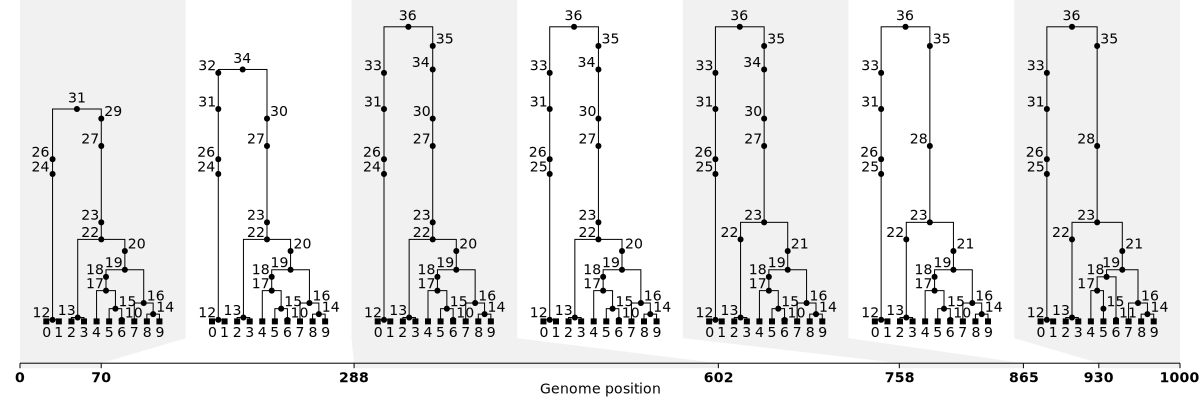

In [8]:
arg.draw_svg(
    size=(1200, 400),  # (width, height) in pixels
    omit_sites=True,  # Later in the workbook we'll remove this, to reveal the variable sites 
)

In [9]:
display_quiz(Workbook1.url + "Q3.json")

<IPython.core.display.Javascript object>

### Branch length changes
Perhaps surprisingly, many recombination events in an ARG do not change the topology of the local trees, but merely change branch lengths (i.e. change the time and identity of the most recent common ancestor, or MRCA, of certain sets of samples). This can be seen most clearly at the top of the graph-based ARG visualization. At 30 000 generations ago there are only two lineages left. Whichever route we take above that through the ARG, will end up joining node 26 and node 23, just at a potentially different time in the past.

In [10]:
display_quiz(Workbook1.url + "Q4.json")

<IPython.core.display.Javascript object>

### "Identical tree" changes

Some recombination events change neither the topology nor the branch lengths. This is seen when going from the third to the fourth tree. That change only involves node ID 24 switching to ID 25, which represents the recombination event at the bottom of the diamond. A peculiarity of ARGs created using the _msprime_ simulator is that for [technical reasons](https://tskit.dev/msprime/docs/stable/ancestry.html#recombination-events), recombination events are recorded as *two* simultanous recombination nodes (e.g. nodes 24/25), representing the paternal and maternal genomes prior to meiosis. These are visually merged into a single node in the ARG visualizer. Assuming a single crossover event, one node is to the left and one to the right of the breakpoint.

<dl class="exercise"><dt>Exercise D</dt>
    <dd>Copy the <code>draw_svg()</code> code above into the box below, and plot the local trees with a y axis, using <code>y_axis=True</code>. To make the Y axis ticks look nicer, you could also specify <code>y_ticks={0: "0", 20_000: "20k", 40_000: "40k"}</code>.</dd>
</dl>

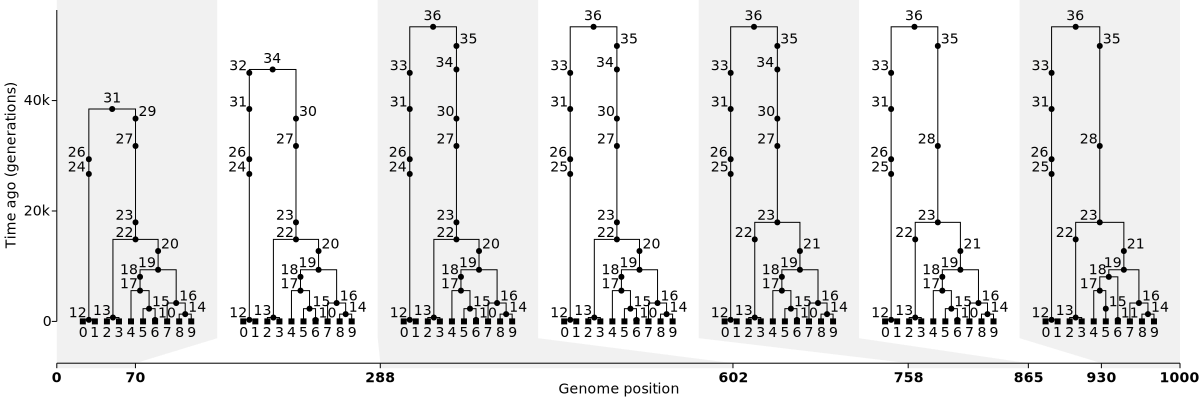

In [11]:
# Complete Exercise D here


## Coalescent and non-coalescent regions

Looking at the tree-by-tree plot, it should be clear that some of the nodes in a local tree have one child in some trees, and two children in others. There are even some nodes that have only one child in every tree in which they appear (e.g. node 26). We can classify nodes into

0. **non-coalescent**, sometimes called _always unary_ (i.e. one child in all local trees, e.g. node 26)
1. **part-coalescent**, sometimes called _locally unary_ (i.e. one child in some local trees, coalescent in others, e.g. node 18)
2. **all-coalescent**, or _never unary_ (always 2 or more children in any local tree in which they are found, e.g. node 19).

<div class="alert alert-block alert-info"><b>Note:</b> This classification will turn out to be important in part B, when we learn about <em>simplifying</em> ARGs by collapsing some nodes (particularly "non-coalescent" nodes) depending on whether they are detectable.</div>

In [12]:
display_quiz(Workbook1.url + "Q5.json")

<IPython.core.display.Javascript object>

The `Workbook.node_coalescence_status()` function, written for this workbook, uses the `.trees()` iterator to construct an array denoting the classification of each node. `returned_array[i]` is **0** if node `i` is non-coalescent, **1** if node `i` is part-coalescent, and **2** if node `i` is all-coalescent. You can check below that this agrees with your understanding:

In [13]:
description = {0: "Non-coalescent", 1: "Part-coalescent", 2: "All-coalescent"}
samples = arg.samples()
for node_id, status in enumerate(Workbook1.node_coalescence_status(arg)):
    extra = ", sample" if node_id in samples else ""
    print(f"Node {node_id} coalescence status: {description[status]} ({status}{extra})")

Node 0 coalescence status: Non-coalescent (0, sample)
Node 1 coalescence status: Non-coalescent (0, sample)
Node 2 coalescence status: Non-coalescent (0, sample)
Node 3 coalescence status: Non-coalescent (0, sample)
Node 4 coalescence status: Non-coalescent (0, sample)
Node 5 coalescence status: Non-coalescent (0, sample)
Node 6 coalescence status: Non-coalescent (0, sample)
Node 7 coalescence status: Non-coalescent (0, sample)
Node 8 coalescence status: Non-coalescent (0, sample)
Node 9 coalescence status: Non-coalescent (0, sample)
Node 10 coalescence status: Non-coalescent (0)
Node 11 coalescence status: Non-coalescent (0)
Node 12 coalescence status: All-coalescent (2)
Node 13 coalescence status: All-coalescent (2)
Node 14 coalescence status: All-coalescent (2)
Node 15 coalescence status: Part-coalescent (1)
Node 16 coalescence status: All-coalescent (2)
Node 17 coalescence status: All-coalescent (2)
Node 18 coalescence status: Part-coalescent (1)
Node 19 coalescence status: All-coa

## Nodes and individuals

You can think of each ARG node as representing a (haploid) genome. Humans (and most other eukaryotes) are *diploid*, meaning they contain 2 genomes: a maternal and a paternal one. 

In _tskit_, this information is stored by allowing a node to be asociated with an individual ID, linked to a separate table of individuals. Usually only sample nodes have positive individual ID. Other nodes have their `individual` ID set to `-1` (also known as `tskit.NULL`); this includes ancestral nodes, as we usually don't know how ancestral genomes were grouped into diploid individuals.

In [15]:
colours = {
    tskit.NULL: "LightGrey",  # nodes that are not associated with an individual are coloured in grey
    0: "LightSeaGreen",
    1: "DeepSkyBlue", 
    2: "MediumVioletRed",
    3: "Coral",
    4: "DarkGoldenRod"
}
for node in arg.nodes():
    individual_id = node.individual
    print(
        f"Node {node.id} is associated with individual {individual_id}",
        f"which we will colour {colours[individual_id]}" if  individual_id != tskit.NULL else ""
    )

Node 0 is associated with individual 1 which we will colour DeepSkyBlue
Node 1 is associated with individual 2 which we will colour MediumVioletRed
Node 2 is associated with individual 4 which we will colour DarkGoldenRod
Node 3 is associated with individual 4 which we will colour DarkGoldenRod
Node 4 is associated with individual 2 which we will colour MediumVioletRed
Node 5 is associated with individual 3 which we will colour Coral
Node 6 is associated with individual 0 which we will colour LightSeaGreen
Node 7 is associated with individual 1 which we will colour DeepSkyBlue
Node 8 is associated with individual 3 which we will colour Coral
Node 9 is associated with individual 0 which we will colour LightSeaGreen
Node 10 is associated with individual -1 
Node 11 is associated with individual -1 
Node 12 is associated with individual -1 
Node 13 is associated with individual -1 
Node 14 is associated with individual -1 
Node 15 is associated with individual -1 
Node 16 is associated wi

When visualising the ARG (either as a graph or as a series of trees), we don't usually want to group the two nodes of each individual together, as the maternal and paternal genomes within an individual can have quite different histories. You can try to rearrange the sample nodes by colour, to convince yourself that the two samples from a single individual do not trivially group together.

Note that the following code does not use the "orthogonal" plot style, but reverts to the default `edge_type` of `"line"`, which simply joins nodes by straight lines. As well as colouring the nodes by individual, it colours recombination nodes as black. It also shows not just the *topology* of the ARG, but also the length (in time) of each edge, by plotting the Y axis on a linear timescale.

In [16]:
import msprime

d3arg.set_node_styles({
    node.id: {"fill": colours[node.individual]}
    for node in arg.nodes()
})
d3arg.draw(title="Nodes coloured by individual", y_axis_scale="time", width=800)

The ARG was actually simulated using a model of human evolution that reflects the Out of Africa event. As well as having a value denoting the <code>individual</code>, each node also has a value indicating a <code>population</code> it belongs to.

<dl class="exercise"><dt>Exercise E</dt>
    <dd>Change the code above to colour by <code>node.population</code> ID rather than <code>node.individual</code> ID. You could also stop colouring the recombination nodes as black if you like.</dd>
</dl>

In [ ]:
display_quiz(Workbook1.url + "Q6.json")

## Mutations

Genetic variation is create by *mutations* on the ARG. So far we have not shown mutations, but we can reveal them by setting `show_mutations` to `True` in the ARG visualizer. If you hover over the orange mutation symbols in the visualization below, their position on the lower genome bar will be revealed.

In [11]:
d3arg.draw(show_mutations=True, y_axis_scale="time", width=800, title=f"ARG with {arg.num_mutations} mutations")

### Encoding sites and mutations in _tskit_

In _tskit_, mutations occur at specific *sites*. A site is defined by a *site id*, a *position* and an *ancestral state*. Mutations are defined as an *mutation id*, a *derived state*, an associated *node id* an (optional) *time*, and an associated *site id*. If two mutations have the same site id, those mutations occur at the same position along the genome.

<dl class="exercise"><dt>Exercise F</dt>
    <dd>The <code>include_mutation_labels</code> and <code>condense_mutations</code> parameters provide different ways to display mutations on branches. Add <code>label_mutations=True</code> to the <code>.draw()</code> method above, to see its effect.</dd>
</dl>

<dl class="exercise"><dt>Exercise G</dt>
    <dd>In the cell below, use <code>arg.draw_svg()</code> to plot the mutated arg as a series of trees <em>without</em> using the <code>omit_mutations</code> parameter. You will see that mutations are drawn as red crosses on the trees, and also depicted as red arrows on the x axis, at the appropriate site position. Multiple mutations at the same site will have those arrows stacked.</dd>
</dl>

In [ ]:
# Complete exercise G here


In [ ]:
display_quiz(Workbook1.url + "Q7.json")

## Genetic variation & the `.variants()` iterator

The inheritance of mutations through the ARG defines the genotypes at each variable site for each sample. The _tskit_ [`.variants()`](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.variants) method goes through the local trees, decoding the genetic variation at each site by looking at the inheritance of mutations. For efficiency, the genotypes for all the samples at a site are returned as a numerical vector. Each value in the vector denotes the index into a corresponding list of alleles:

In [12]:
for variant in arg.variants():
    print(
        f"Genotypes at position {variant.site.position}",
        f"for the {arg.num_samples} samples ",
        f"are {variant.genotypes},",
        f"denoting the alleles {variant.alleles}",
    )

Genotypes at position 5.0 for the 10 samples  are [1 1 2 2 0 0 0 0 0 0], denoting the alleles ('A', 'G', 'T')
Genotypes at position 92.0 for the 10 samples  are [0 0 0 0 1 0 0 0 0 0], denoting the alleles ('G', 'T')
Genotypes at position 215.0 for the 10 samples  are [0 0 0 0 0 0 0 1 1 1], denoting the alleles ('C', 'A')
Genotypes at position 251.0 for the 10 samples  are [1 1 0 0 0 0 0 0 0 0], denoting the alleles ('A', 'T')
Genotypes at position 378.0 for the 10 samples  are [1 1 0 0 0 0 0 0 0 0], denoting the alleles ('A', 'G')
Genotypes at position 439.0 for the 10 samples  are [1 1 0 0 0 0 0 0 0 0], denoting the alleles ('C', 'G')
Genotypes at position 560.0 for the 10 samples  are [0 0 1 1 1 1 1 1 1 1], denoting the alleles ('C', 'G')
Genotypes at position 583.0 for the 10 samples  are [0 0 1 1 0 0 0 0 0 0], denoting the alleles ('C', 'A')
Genotypes at position 590.0 for the 10 samples  are [1 1 0 0 0 0 0 0 0 0], denoting the alleles ('A', 'G')
Genotypes at position 835.0 for the

<dl class="exercise"><dt>Exercise H</dt>
    <dd>Change the code above to display the actual allelic states (rather that a numerical value), by using the <a href="https://tskit.dev/tskit/docs/stable/python-api.html#tskit.Variant.states"><code>variant.states()</code></a> method in place of accessing <a href="https://tskit.dev/tskit/docs/stable/python-api.html#tskit.Variant.genotypes"><code>variant.genotypes</code></a> directly. This can be useful for displaying or checking smaller examples, as opposed to numerical analysis of larger datasets.</dd>
</dl>

In [13]:
display_quiz(Workbook1.url + "Q8.json")

<IPython.core.display.Javascript object>

## Mutations allow ARG inference

Mutations on an ARG generate genetic variation. Conversely, genetic variation among a set of samples can be used to *infer* an ARG that could plausibly have generated the samples. To do this, it is often useful to make the "infinite sites" approximation, that every mutation occurs at a different position (as we saw above, this is not always true).

When we use mutations do infer genealogy, it can be helpful to *polarise* the alleles at a genetic site (figure out which allele is ancestral and which are derived). Then we can reasonably assume that if a set of genomes share the derived allele, they all inherited it from a common ancestor. This allows us to deduce the presence of a common ancestor node in the ARG.



In [14]:
display_quiz(Workbook1.url + "Q9.json")

<IPython.core.display.Javascript object>

## Population genetic statistics

An ARG with mutations completely summarises the genetic variation present in the samples. Moreover, by only looking at differences between local trees, genome-wide statistical calculations can often be performed much more efficiently than naive approaches. Details of the statistics available in _tskit_ (including genetic divergence, Patterson's f statistics, PCA and genetic relatedness, etc) are at [https://tskit.dev/tskit/docs/stable/stats.html](https://tskit.dev/tskit/docs/stable/stats.html). Many of these statistics are summaries of the _allele frequency spectrum_, which itself can be returned by a single call to the [`.allele_frequency_spectrum()`](https://tskit.dev/tskit/docs/stable/stats.html#sec-stats-notes-afs) method:

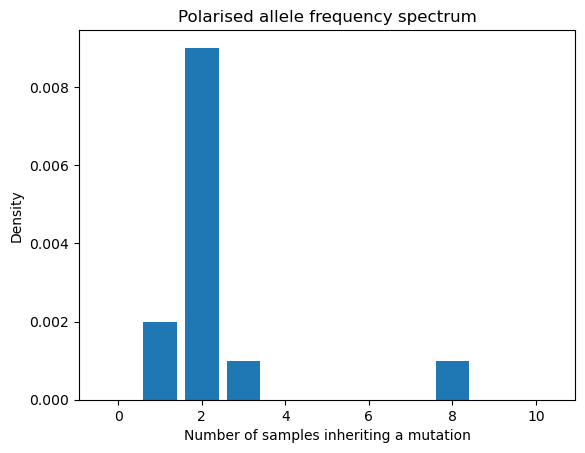

In [15]:
from matplotlib import pyplot as plt


# Whole genome AFS
afs = arg.allele_frequency_spectrum(polarised=True)
plt.bar(range(arg.num_samples + 1), afs)
plt.xlabel("Number of samples inheriting a mutation")
plt.ylabel("Density")
plt.title("Polarised allele frequency spectrum")
plt.show()

<dl class="exercise"><dt>Exercise I</dt>
    <dd>Add <code>span_normalise=False</code> to the <code>.allele_frequency_spectrum()</code> call above, and re-run, so that the Y axis plots the actual number of mutations instead dividing that by the sequence length. Does the number of mutations in all the bars add up to the total number in the ARG?</dd>
</dl>

### Windowed statistics

Statistics can also be windowed along the genome and also by time. Here we demonstrate a simplest measure, the genetic diversity (sometimes known as $\pi$), and a more complex one, Wright's Fst.

Average genetic diversity (π) = 0.004333333333333334
Average Fst = 0.0843373493975903


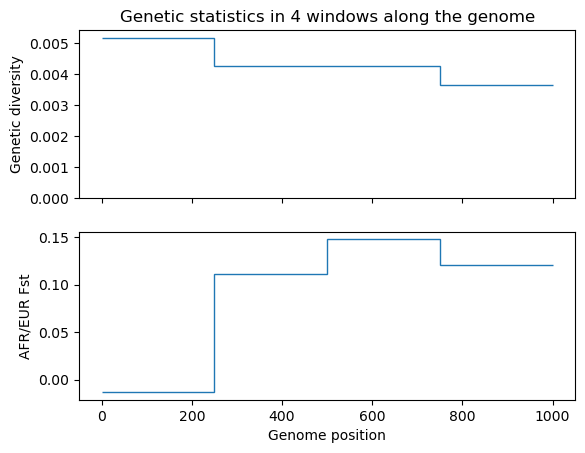

In [16]:
print(f"Average genetic diversity (π) = {arg.diversity()}")
AFR_samples = arg.samples(population=0)
EUR_samples = arg.samples(population=1)

print(f"Average Fst = {arg.Fst([AFR_samples, EUR_samples])}")

# Now show this in windows
genome_windows = [0, 250, 500, 750, 1000]
windowed_diversity = arg.diversity(windows=genome_windows)
windowed_Fst = arg.Fst([AFR_samples, EUR_samples], windows=genome_windows)

fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True)
ax_top.stairs(windowed_diversity, genome_windows, baseline=None)
ax_top.set_ylabel("Genetic diversity")
ax_top.set_title(f"Genetic statistics in {len(genome_windows) - 1} windows along the genome")
ax_bottom.stairs(windowed_Fst, genome_windows, baseline=None)
ax_bottom.set_ylabel("AFR/EUR Fst")
ax_bottom.set_xlabel("Genome position")

plt.show()

### Do you need genetic variation?

It is worth noting that if you have the genealogy, then an alternative set of statistics exist which can be less noisy than those based on the raw genetic variation data. See https://tskit.dev/tutorials/no_mutations.html for more details.

These "branch" mode statistics do not require mutations, and so do not contain noise associated with the mutational process. For instance, as our ARG was created under a simple neutral model, we would expect the genetic statistics along the genome to be constant. And indeed, using `mode="branch"` results in a comparable windowed genome plot, in which the genetic statistics are less noisy than those based on the genetic variation created by mutations.

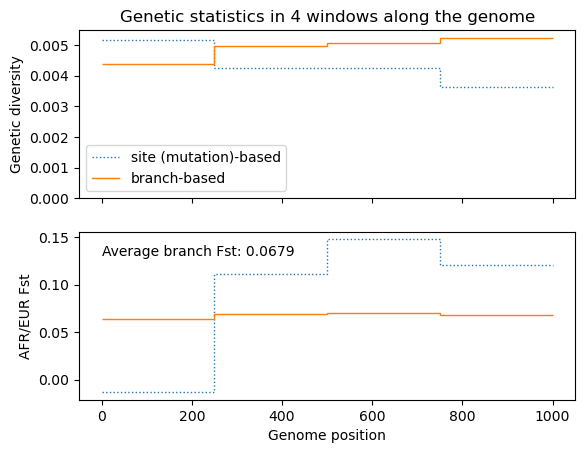

In [17]:
branch_Fst = arg.Fst([AFR_samples, EUR_samples], windows=genome_windows, mode="branch")
branch_diversity = arg.diversity(windows=genome_windows, mode="branch")
scaled_branch_diversity = branch_diversity * mutation_rate


fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True)
ax_top.stairs(windowed_diversity, genome_windows, baseline=None, ls=":", label="site (mutation)-based")
ax_top.stairs(scaled_branch_diversity, genome_windows, baseline=None, label="branch-based")
ax_top.set_ylabel("Genetic diversity")
ax_top.set_title(f"Genetic statistics in {len(genome_windows) - 1} windows along the genome")
ax_bottom.stairs(windowed_Fst, genome_windows, baseline=None, ls=":", label="site (mutation)-based")
ax_bottom.stairs(branch_Fst, genome_windows, baseline=None, label="branch-based")
ax_bottom.text(0, 0.13, f'Average branch Fst: {arg.Fst([AFR_samples, EUR_samples], mode="branch"):.4f}')
ax_bottom.set_ylabel("AFR/EUR Fst")

ax_bottom.set_xlabel("Genome position")
ax_top.legend()
plt.show()

In [ ]:
display_quiz(Workbook1.url + "Q10.json")

We will encounter other summary statistics in future workshops

## Extra *tskit* details

This is the end of part A. However, if you are interested and have time left, this section briefly explains how ARGs are stored within _tskit_, and how to access the raw data underlying a _tskit_ ARG.

### Tables

Nodes, edges, individual, sites, and mutations are all stored as *rows* in a set of separate *tables*. Together these constitute a [TableCollection](https://tskit.dev//tables_and_editing.html). You can see a summary of the tables by simply displaying a tree sequence in a notebook: this describes the number of rows in each table, and the size of each table. Below you will see that our `arg` has 42 edges, 37 nodes, and 13 mutations at 12 different sites along the genome:

In [18]:
display(arg)

Each of the tables can also be displayed separately, using `arg.tables.nodes`, `arg.tables.edges`, etc. Printing a table or the whole table collection creates a plain-text representation (helpful e.g. if you are not using a notebook):

In [19]:
print(arg.tables)

TableCollection

Sequence Length: 1000.0
Time units: generations
Metadata: b''

Individuals
╔══╤═════╤════════╤═══════╤════════════════╗
║id│flags│location│parents│metadata        ║
╠══╪═════╪════════╪═══════╪════════════════╣
║0 │    0│        │       │ {'name': 'Bob'}║
║1 │    0│        │       │ {'name': 'Eve'}║
║2 │    0│        │       │ {'name': 'Sam'}║
║3 │    0│        │       │{'name': 'Lucy'}║
║4 │    0│        │       │ {'name': 'Joe'}║
╚══╧═════╧════════╧═══════╧════════════════╝

Nodes
╔══╤══════╤══════════╤══════════╤═══════════════╤══════════════╗
║id│flags │population│individual│time           │metadata      ║
╠══╪══════╪══════════╪══════════╪═══════════════╪══════════════╣
║0 │     1│         0│         1│     0.00000000│{'label': 'A'}║
║1 │     1│         0│         2│     0.00000000│{'label': 'B'}║
║2 │     1│         1│         4│     0.00000000│{'label': 'C'}║
║3 │     1│         1│         4│     0.00000000│{'label': 'D'}║
║4 │     1│         0│         2│     0.0

It should be reasonably obvious how this works. E.g. edge 0 connects parent node 10 to child node 6 in the part of the genome that spans 0 to 930 bp. For further information see [https://tskit.dev/tskit/docs/stable/data-model.html](https://tskit.dev/tskit/docs/stable/data-model.html), and for a tutorial approach, see [https://tskit.dev/tutorials/tables_and_editing.html](https://tskit.dev/tutorials/tables_and_editing.html).

As a brief introduction, you can access particular edges, nodes, sites, etc. as Python objects using `arg.edge(i)`, `arg.node(i)`, `arg.site(i)`, and so on.

In [20]:
print(arg.edge(0))

Edge(left=0.0, right=930.0, parent=10, child=6, metadata=b'', id=0)


In [21]:
print(arg.node(10))
print(arg.node(6))
individual_id_for_node_6 = arg.node(6).individual

Node(id=10, flags=131072, time=260.96659439832086, population=0, individual=-1, metadata={})
Node(id=6, flags=1, time=0.0, population=0, individual=0, metadata={'label': 'G'})


In [22]:
print(arg.individual(individual_id_for_node_6))

Individual(id=0, flags=0, location=array([], dtype=float64), parents=array([], dtype=int32), nodes=array([6, 9], dtype=int32), metadata={'name': 'Bob'})


In [23]:
print(arg.mutation(0))

Mutation(id=0, site=0, node=12, derived_state='G', parent=-1, metadata=b'', time=17727.360320461674, edge=24)


In [24]:
print(arg.site(0))

Site(id=0, position=5.0, ancestral_state='A', mutations=[Mutation(id=0, site=0, node=12, derived_state='G', parent=-1, metadata=b'', time=17727.360320461674, edge=24), Mutation(id=1, site=0, node=13, derived_state='T', parent=-1, metadata=b'', time=10727.06282652073, edge=20)], metadata=b'')


#### High performance data access

However, the most performant way to access the underlying data is to use the [efficient column accessors](https://tskit.dev/tskit/docs/stable/python-api.html#efficient-table-column-access), which provide _numpy_ arrays that are a direct view into memory. For example, to find all the site positions along the genome, you can use  `arg.sites_position`. This is particularly relevant when dealing with ARGs containing large tables (e.g. millions of rows).

In [25]:
arg.sites_position

array([  5.,  92., 215., 251., 378., 439., 560., 583., 590., 835., 973.,
       992.])

In [26]:
arg.edges_parent

array([10, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19,
       19, 20, 21, 22, 22, 23, 23, 24, 25, 26, 26, 27, 28, 29, 30, 31, 31,
       32, 33, 34, 34, 35, 35, 36, 36], dtype=int32)

In [27]:
arg.edges_child

array([ 6,  6,  0,  1,  2,  3,  8,  9,  5, 10,  7, 14,  4, 15, 11, 17, 16,
       18, 19, 19, 13, 20, 21, 22, 12, 12, 24, 25, 23, 23, 27, 27, 26, 29,
       31, 31, 30, 32, 28, 34, 33, 35], dtype=int32)

and so on. Note that there are also [direct memory access methods](https://tskit.dev/tskit/docs/stable/python-api.html#array-access) for local trees in a tree sequence. 

<!-- For more information about writing high performance algorithms, see https://github.com/tskit-dev/tutorials/issues/151 (not yet written) -->